## Introducing time series via dynamic linear model

Reference: https://cran.r-project.org/web/packages/dlm/vignettes/dlm.pdf

In [1]:
library(dlm)

#### Dynamic Linear Model

Turns out that our initial expression is a special case of a class of models called **dynamic linear models** that has the general expression as:

$Y_t = F_t \theta_t + v_t$

$\theta_t = G_t \theta_{t-1} + w_t$

$\theta_0 \sim N(m_0, C_0)$

We generally assume that the random terms, $v_t$, $w_t$ following a Normal/Gaussian distribution with mean 0:

$v_t\sim N(0, V_t)$

$w_t\sim N(0, W_t)$

#### Our simple time series setup 

$Y_t = \theta_t + v_t$

$\theta_t = \theta_{t-1} + w_t$

#### Fitting our problem into the Dynamic Linear Model

The Dynamic Linear Model is a more complex model relative to our "simplest time series" above. What does our simple problem imply about different parameters in the DLM setup?

- $F_t = 1$
- $G_t = 1$

- Notice how neither term has the subscript $t$
- We will likely also assume that $V_t = \sigma^2_v$ and $W_t=\sigma^2_w$

In [3]:
base_mod <- dlm(FF=matrix(1, ncol=1, nrow=1),
                GG=matrix(1, ncol=1, nrow=1),
                V=1, W=3, m0=20, C0=20^2)

In [4]:
tmax_ts <- read.csv("tmax_time_series.csv")$x

In [5]:
head(tmax_ts)

[1]    NA    NA    NA 11.43 18.46 24.14

In [6]:
kfilt <- dlmFilter(tmax_ts, base_mod)

In [146]:
class(kfilt)

[1] "dlmFiltered"

In [7]:
names(kfilt)

[1] "y"   "mod" "m"   "U.C" "D.C" "a"   "U.R" "D.R" "f"

In [8]:
# These are the "theta" values
head(kfilt$m)

[1] 20.00000 20.00000 20.00000 20.00000 11.45075 17.05747

In [9]:
length(kfilt$m)

[1] 1537

In [10]:
length(tmax_ts)

[1] 1536

In [12]:
month_index <- 1:length(tmax_ts)

In [14]:
tail(month_index)

[1] 1531 1532 1533 1534 1535 1536

In [149]:
length(tmax_ts)

[1] 1536

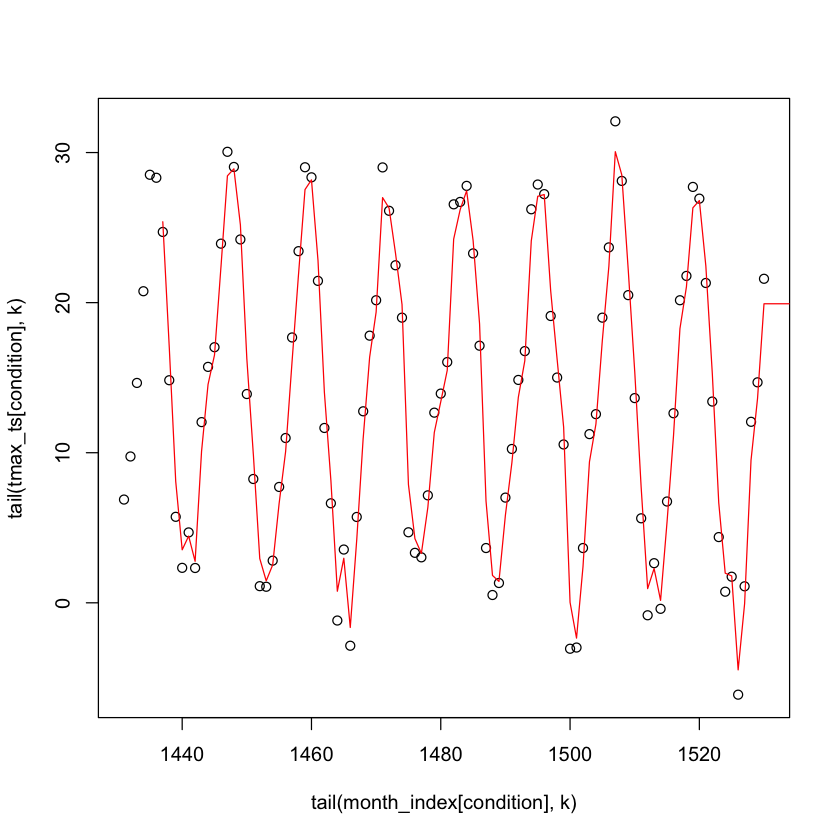

In [16]:
#par(mfrow=c(1, 2))
condition <- !is.na(tmax_ts)
#plot(month_index[condition], tmax_ts[condition])
#lines(month_index, kfilt$m[-1], col="red")
k <- 100
plot(tail(month_index[condition], k), tail(tmax_ts[condition], k))
lines(tail(month_index, k), tail(kfilt$m[-1], k), col="red")

In [18]:
residual <- tmax_ts - kfilt$m[-1]

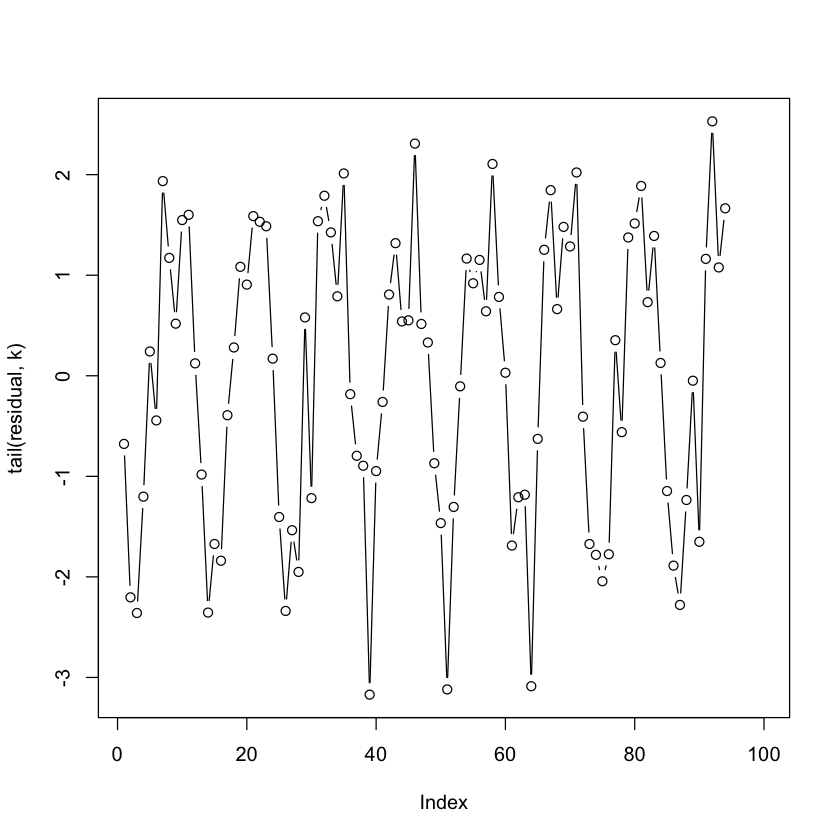

In [19]:
plot(tail(residual, k), type="b")

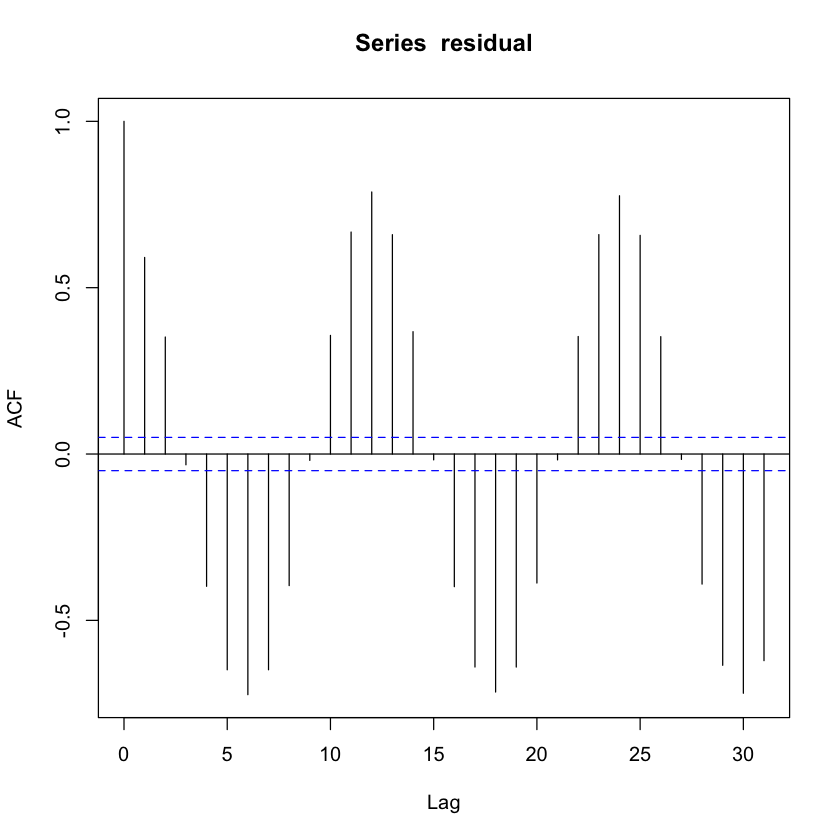

In [22]:
acf(residual, na.action = na.pass)

In [153]:
names(kfilt)

[1] "y"   "mod" "m"   "U.C" "D.C" "a"   "U.R" "D.R" "f"

In [154]:
kfilt$mod

$FF
     [,1]
[1,]    1

$V
     [,1]
[1,]    1

$GG
     [,1]
[1,]    1

$W
     [,1]
[1,]    3

$m0
[1] 20

$C0
     [,1]
[1,]  400


### QUESTION: Remove the $\exp$ operation in the code below, an error should show up, why do you think showed up?

In [23]:
# x has to be a vector
obj <- function(x){
    dlm(FF=1, GG=x[1], V=exp(x[2]),
        W=exp(x[3]), m0=20, C0=20^2)
}
# MLE = maximum likelihood estimator
# "par" are initial values for the optimization, this is where the "search" starts
opt_out <- dlmMLE(tmax_ts, par=c(1, 1, 3), build=obj)

In [24]:
names(opt_out)

[1] "par"         "value"       "counts"      "convergence" "message"

In [25]:
opt_out$convergence

[1] 0

In [26]:
opt_out

$par
[1]   0.9300794 -12.0909826   3.5871235

$value
[1] 3437.56

$counts
function gradient 
      41       41 

$convergence
[1] 0

$message
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

In [28]:
sqrt(exp(-12.0909826443015))

[1] 0.002368517

In [244]:
obj(opt_out$par)

$FF
     [,1]
[1,]    1

$V
             [,1]
[1,] 5.609872e-06

$GG
          [,1]
[1,] 0.9300794

$W
      [,1]
[1,] 36.13

$m0
[1] 20

$C0
     [,1]
[1,]  400


In [29]:
opt_mod <- dlm(FF=1, GG=opt_out$par[1], V=exp(opt_out$par[2]), W=exp(opt_out$par[3]), m0=20, C0=20^2)
kfilt <- dlmFilter(tmax_ts, opt_mod)

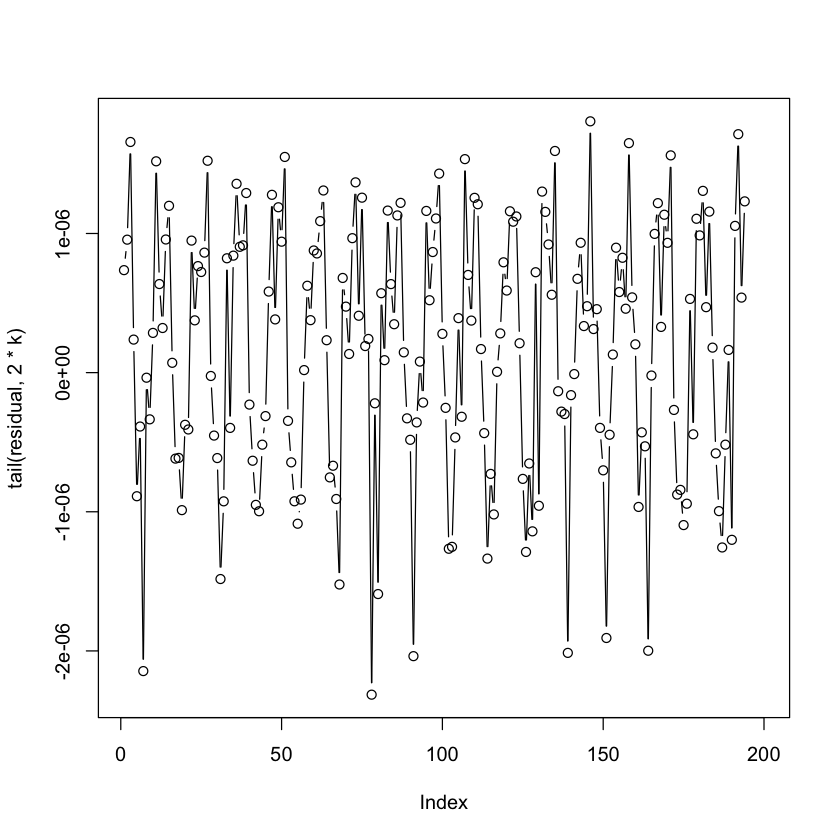

In [32]:
# TOO GOOD TO BE TRUE!
# Overfitting!
residual <- tmax_ts - kfilt$m[-1]
plot(tail(residual, 2 * k), type="b")

#### Look at the auto-regress function

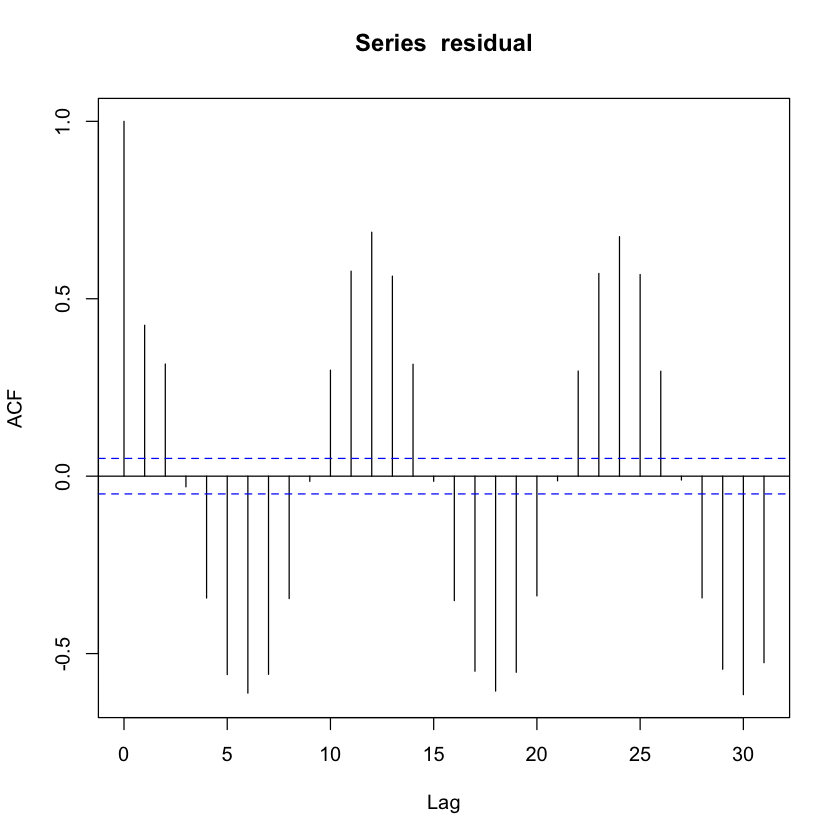

In [33]:
acf(residual, na.action=na.pass)

#### How can we remove the cyclical pattern in the residuals?

What if we tried:

$Y_t = \theta_t + v_t$

$\theta_t = \theta_{t-1} \beta_1 + \theta_{t-2} \beta_2 + w_t$

We need to re-write our equations using matrices

## QUESTION: Fill in the spots with "?" below

$F = \begin{bmatrix} 0 & 1 & 0 \end{bmatrix}$

$\Theta_t = \begin{bmatrix} 1 \\ \theta_{t} \\ \theta_{t-1} \end{bmatrix}$

$G = \begin{bmatrix} 1 & 0 & 0 \\ 0 & ? & ?  \\ ? & ? & ? \end{bmatrix}$

You should check the math works out!

$Y_t = F \Theta_t + v_t$

$\Theta_t = G \Theta_{t-1} + \Omega_t$

$\Omega_t = \begin{bmatrix} 0\\ w_t\\ w_{t-1} \end{bmatrix}$

In [196]:
obj <- function(x){
    dlm(
      FF=matrix(c(0, 1, 0), ncol=3),
      GG=matrix(c(1, 0, 0, 0, ?, ?, ?, ?, ?), ncol=3, byrow=TRUE),
      V=matrix(exp(x[3]), ncol=1),
      W=matrix(c(0, 0, 0, 0, exp(x[4]), 0, 0, 0, exp(x[5])), ncol=3),
      m0=matrix(c(1, 20, 0), ncol=1),
      C0=diag(c(100, 100, 100)))
    }

### Try using dlm() and dlmFilter() 

- hint, check the type of "m" after fitting the dlmFilter()

#### Optional: What happens if fitted the Kalman Filter to the residuals?

#### Compare the residuals from this exercise to the "best model" before.